In [70]:
import csv
import numpy as np
import pandas as pd
import matplotlib.style
import matplotlib.pyplot as plt
year = 2020
#dati https://geodati.gov.it:443/geoportalRNDTPA/catalog/search/resource/details.page?uuid=PCM:COVID-19:05032020:093000
#aree https://geodati.gov.it/geoportalRNDTPA/catalog/search/resource/details.page?uuid=PCM:000086:20200306:110700
#dati nazionale https://github.com/pcm-dpc/COVID-19/tree/master/dati-andamento-nazionale
#dati regionale https://github.com/pcm-dpc/COVID-19/tree/master/dati-regioni
#dati province https://github.com/pcm-dpc/COVID-19/tree/master/dati-province
cvs_regionale_fileurl = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
months_days=(('02','24'),('02','25'),('02','26'),('02','27'),('02','28'),('02','29'),
             ('03','01'),('03','02'),('03','03'),('03','04'),('03','05'),('03','06'),
             ('03','07'),('03','08'),('03','09'),('03','10'),('03','11'),('03','12'),
             ('03','13'),('03','14'),('03','15'),('03','16'),('03','17'),('03','18'),
             ('03','19'),('03','20'),('03','21'))

#Population from Wikipedia, retrieved 18.03.2020
regions_pd = pd.DataFrame([
    [1,'Piemonte', 4356406],
    [2,"Valle d'Aosta", 125666],
    [3,'Lombardia', 10060574],
    [4,'P.A. Bolzano', 533050],
    [104,'P.A. Trento', 541380],
    [5,'Veneto', 4905854],
    [6,'Friuli Venzia Giulia', 1215220],
    [7,'Liguria', 1550640],
    [8,'Emilia-Romagna', 4459477],
    [9,'Toscana', 3729641],
    [10,'Umbria', 882015],
    [11,'Marche', 1525271],
    [12,'Lazio', 5879082],
    [13,'Abruzzo', 1311580],
    [14,'Molise', 305617],
    [15,'Campania', 5801692],
    [16,'Puglia', 4029053],
    [17,'Basilicata', 562869],
    [18,'Calabria', 1947131],
    [19,'Sicilia', 4999891],
    [20,'Sardegna', 1639591]], columns=['code','region','P']) # P:population


In [71]:
# data,stato,codice_regione,denominazione_regione,lat,long,
# 1.ricoverati_con_sintomi,2.terapia_intensiva, 3. totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
# 2020-02-24 18:00:00,ITA,13,Abruzzo,42.35122196,13.39843823,0,0,0,0,0,0,0,0,0,5
# 2020-02-24 18:00:00,ITA,17,Basilicata,40.63947052,15.80514834,0,0,0,0,0,0,0,0,0,0
dtype_andamento_regionale="datetime64[s],S3,i8,S21,f8,f8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8"


In [72]:
rows_np = np.genfromtxt( 
        cvs_regionale_fileurl,
        dtype = dtype_andamento_regionale,
        delimiter=',', 
        names=True)

In [73]:
rows_pd = pd.DataFrame(rows_np)

# Index(['data', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
#        'long', 'ricoverati_con_sintomi', 'terapia_intensiva',
#        'totale_ospedalizzati', 'isolamento_domiciliare',
#        'totale_attualmente_positivi', 'nuovi_attualmente_positivi',
#        'dimessi_guariti', 'deceduti', 'totale_casi', 'tamponi'],
#       dtype='object')

rows_pd.rename(columns={'data':'date',
                        'ricoverati_con_sintomi':'h', #hospitalized
                        'terapia_intensiva':'icu',
                        'totale_ospedalizzati':'h+icu', 
                        'isolamento_domiciliare':'q', #quarantine
                        'totale_attualmente_positivi': 'p', #positives
                        'nuovi_attualmente_positivi': 'np', #new positives
                        'dimessi_guariti':'d', #discharged 
                        'deceduti':'dc', #deceased 
                        'totale_casi':'T', 
                        'tamponi': 'S' #swabs
                       }, inplace=True)

rows_pd.index

RangeIndex(start=0, stop=588, step=1)

In [74]:
# b'P.A. Trento' and b'P.A. Bolzano' both share codice_regione==4 - setting P.A.Trento to 104
rows_pd.loc[rows_pd['denominazione_regione']==b'P.A. Trento','codice_regione']=104
#merge population from regions_pd
rows_pd=pd.merge(rows_pd, regions_pd, how='left', left_on='codice_regione', right_on='code',
         left_index=False, right_index=False, copy=True, 
         validate="m:1")

rows_pd.columns

Index(['date', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
       'long', 'h', 'icu', 'h+icu', 'q', 'p', 'np', 'd', 'dc', 'T', 'S',
       'code', 'region', 'P'],
      dtype='object')

In [75]:
last_day_of_data = rows_pd['date'].max().floor('D')
#latest_pd = rows_pd.loc[rows_pd['data'] > pd.Timestamp('2020-03-22')]
latest_pd = rows_pd.loc[rows_pd['date'] > last_day_of_data]

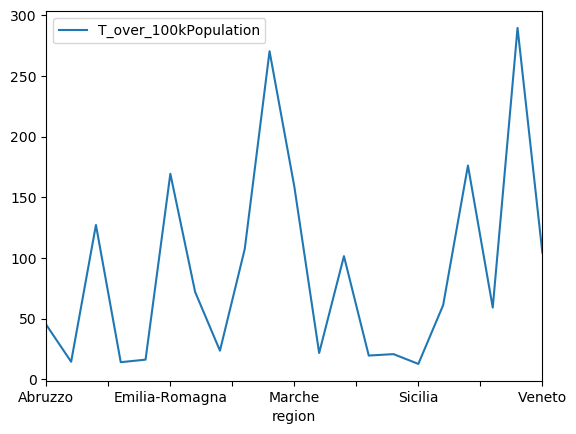

In [76]:
rows_pd.loc[:,'T_over_100kPopulation']=rows_pd['T'].div(rows_pd['P']).mul(100000)
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html?highlight=plot#pandas.DataFrame.plot
#latest_pd.plot(y='T_over_100kPopulation', x='region') # y='Positives per 100k inhabitants', x='region')
latest_pd = rows_pd.loc[rows_pd['date'] > last_day_of_data]
latest_pd.plot(y='T_over_100kPopulation', x='region') # y='Positives per 100k inhabitants', x='region')

<Figure size 1200x800 with 0 Axes>

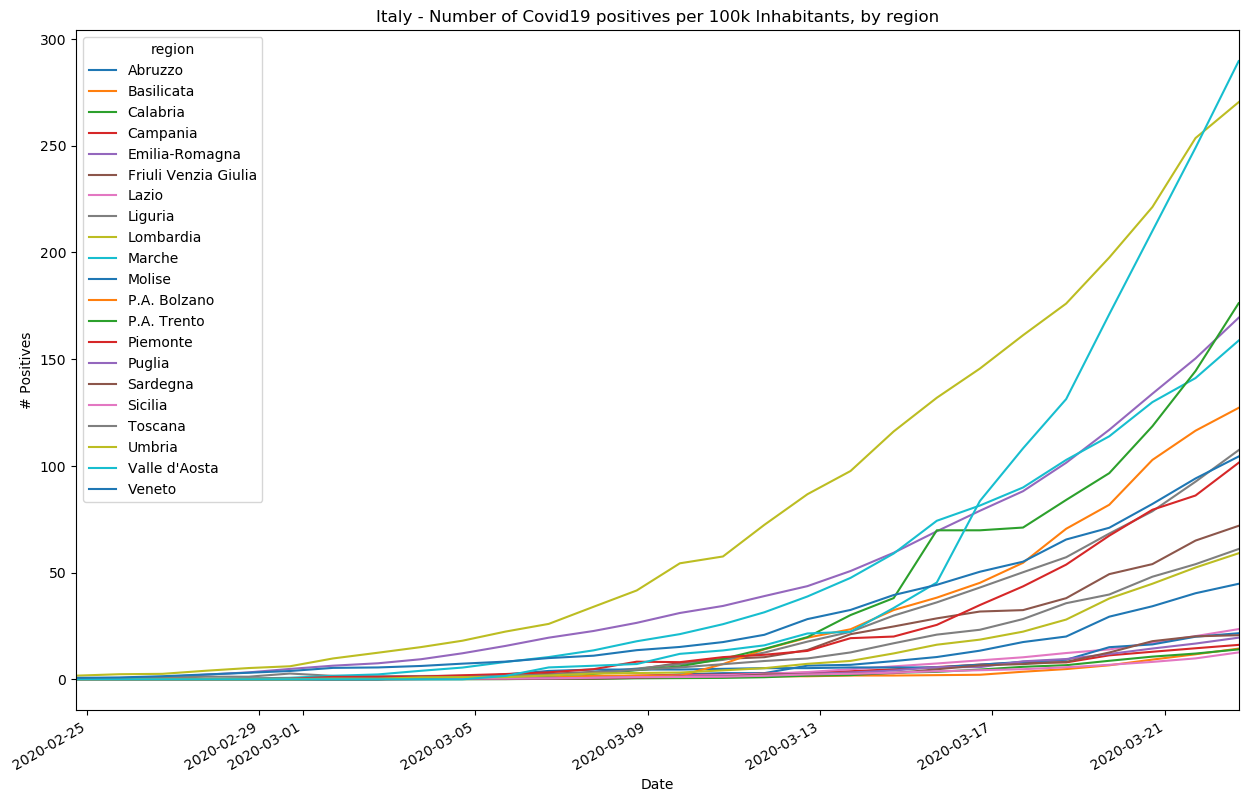

In [78]:
#rows_pd.groupby('code').plot(y='T_over_100kPopulation', x='date')
matplotlib.style.use('default')
fig = plt.figure(figsize=(15,10), dpi=80)
Tover100k_plt = rows_pd.pivot(index='date',columns='region')['T_over_100kPopulation'].plot()
Tover100k_plt.set_ylabel('# Positives')
Tover100k_plt.set_xlabel('Date')
Tover100k_plt.set_title('Italy - Number of Covid19 positives per 100k Inhabitants, by region')
#fig.add_axes(Tover100k_plt)
Tover100k_plt.get_figure().set_size_inches(15, 10, forward=True)
plt.savefig('Tper100kP.png', format='png', dpi=80)


In [67]:
Tover100kP_table = rows_pd.loc[rows_pd['date']>last_day_of_data - pd.Timedelta('7 days')].pivot(index='date',columns='region')['T_over_100kPopulation'].T.iloc[:,[0,-1]].round(1)
Tover100kP_table['Growth (linear)'] = Tover100kP_table.iloc[:,1].div(Tover100kP_table.iloc[:,0]).sub(1).mul(100).round(0).astype(str) + '%'
#Tover100kP_table.columns
Tover100kP_table

date,2020-03-15 17:00:00,2020-03-22 17:00:00,Growth (linear)
region,,,
Abruzzo,10.4,44.8,331.0%
Basilicata,2.0,14.4,620.0%
Calabria,3.5,14.0,300.0%
Campania,5.7,16.1,182.0%
Emilia Romagna,69.4,169.4,144.0%
Friuli Venzia Giulia,28.6,71.9,151.0%
Lazio,7.4,23.5,218.0%
Liguria,36.0,107.4,198.0%
Lombardia,131.9,270.4,105.0%


In [69]:
print(Tover100kP_table.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>date</th>
      <th>2020-03-15 17:00:00</th>
      <th>2020-03-22 17:00:00</th>
      <th>Growth (linear)</th>
    </tr>
    <tr>
      <th>region</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Abruzzo</th>
      <td>10.4</td>
      <td>44.8</td>
      <td>331.0%</td>
    </tr>
    <tr>
      <th>Basilicata</th>
      <td>2.0</td>
      <td>14.4</td>
      <td>620.0%</td>
    </tr>
    <tr>
      <th>Calabria</th>
      <td>3.5</td>
      <td>14.0</td>
      <td>300.0%</td>
    </tr>
    <tr>
      <th>Campania</th>
      <td>5.7</td>
      <td>16.1</td>
      <td>182.0%</td>
    </tr>
    <tr>
      <th>Emilia Romagna</th>
      <td>69.4</td>
      <td>169.4</td>
      <td>144.0%</td>
    </tr>
    <tr>
      <th>Friuli Venzia Giulia</th>
      <td>28.6</td>
      <td>71.9</td>
      <td>151.0%</td>
    </tr>
    <tr>
      <th>Lazio</th>

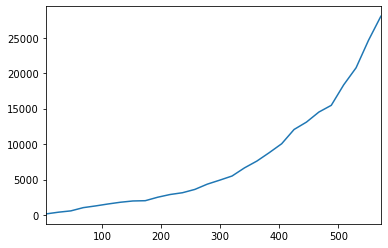

In [23]:
rows_pd[rows_pd['codice_regione']==8]['tamponi'].plot()

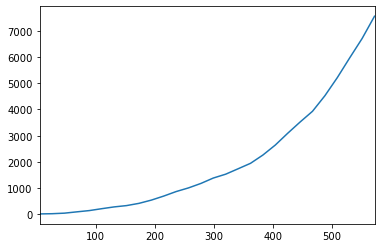

In [62]:
rows_pd[rows_pd['codice_regione']==8]['totale_casi'].plot()

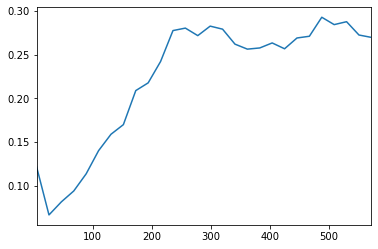

In [44]:
#positivi su tamponi
rows_pd['T_positives_over_swabs']=rows_pd['totale_casi'].div(rows_pd['tamponi'], fill_value=0)
rows_pd[rows_pd['codice_regione']==8]['T_positives_over_swabs'].plot()

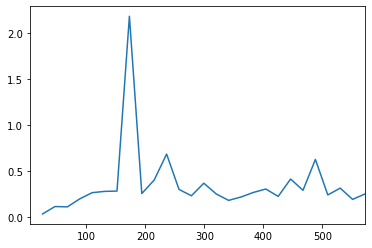

In [61]:
#positivi su tamponi - ma differenze
rows_pd['delta_T'] = rows_pd.groupby('codice_regione')['totale_casi'].diff()
rows_pd['delta_S'] = rows_pd.groupby('codice_regione')['tamponi'].diff()
rows_pd['delta_T_over_delta_S'] = rows_pd['delta_T'].div(rows_pd['delta_S'], fill_value=0.0001)
rows_pd[rows_pd['codice_regione']==8]['delta_T_over_delta_S'].plot()

In [45]:
rows_pd[rows_pd['codice_regione']==8].tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,T_positives_over_swabs
488,2020-03-18 17:00:00,b'ITA',8,b'Emilia Romagna',44.494367,11.341721,1784,247,2031,1884,3915,511,152,458,4525,15461,0.292672
509,2020-03-19 17:00:00,b'ITA',8,b'Emilia Romagna',44.494367,11.341721,1900,260,2160,2346,4506,591,177,531,5214,18344,0.284235
530,2020-03-20 17:00:00,b'ITA',8,b'Emilia Romagna',44.494367,11.341721,2083,267,2350,2739,5089,583,239,640,5968,20753,0.287573
551,2020-03-21 17:00:00,b'ITA',8,b'Emilia Romagna',44.494367,11.341721,2267,265,2532,3129,5661,572,329,715,6705,24620,0.272340
572,2020-03-22 17:00:00,b'ITA',8,b'Emilia Romagna',44.494367,11.341721,2429,269,2698,3692,6390,729,349,816,7555,28022,0.269610


In [42]:
rows_pd.tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,T_positives_over_swabs
583,2020-03-22 17:00:00,b'ITA',9,b'Toscana',43.769231,11.255889,706,215,921,1223,2144,239,42,91,2277,13264,0.171668
584,2020-03-22 17:00:00,b'ITA',4,b'P.A. Trento',46.068935,11.121231,235,46,281,604,885,165,34,35,954,3050,0.312787
585,2020-03-22 17:00:00,b'ITA',10,b'Umbria',43.106758,12.388247,97,35,132,368,500,53,5,16,521,3135,0.166188
586,2020-03-22 17:00:00,b'ITA',2,"b""Valle d'Aosta""",45.737503,7.320149,63,21,84,270,354,50,1,9,364,950,0.383158
587,2020-03-22 17:00:00,b'ITA',5,b'Veneto',45.434905,12.338452,1113,255,1368,3276,4644,430,309,169,5122,57671,0.088814


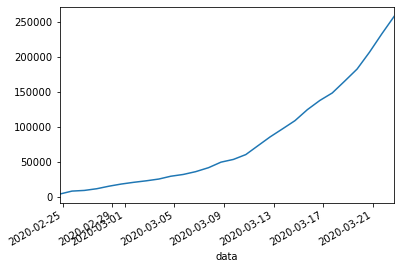

In [25]:
rows_pd.groupby(['data'])['tamponi'].sum().plot()

In [30]:
rows_pd[rows_pd['codice_regione']==8].tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
488,2020-03-18 17:00:00,b'ITA',8,b'Emilia Romagna',44.494367,11.341721,1784,247,2031,1884,3915,511,152,458,4525,15461
509,2020-03-19 17:00:00,b'ITA',8,b'Emilia Romagna',44.494367,11.341721,1900,260,2160,2346,4506,591,177,531,5214,18344
530,2020-03-20 17:00:00,b'ITA',8,b'Emilia Romagna',44.494367,11.341721,2083,267,2350,2739,5089,583,239,640,5968,20753
551,2020-03-21 17:00:00,b'ITA',8,b'Emilia Romagna',44.494367,11.341721,2267,265,2532,3129,5661,572,329,715,6705,24620
572,2020-03-22 17:00:00,b'ITA',8,b'Emilia Romagna',44.494367,11.341721,2429,269,2698,3692,6390,729,349,816,7555,28022


In [34]:
rows_pd[['totale_attualmente_positivi']]

,totale_attualmente_positivi
0,0
1,0
2,0
3,0
4,0
5,18
6,0
7,2
8,0
9,166


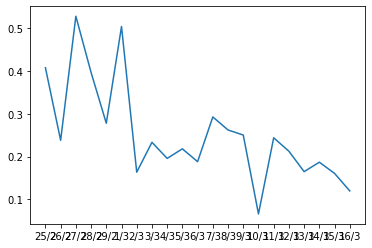

In [124]:
growth_daily_num = np.diff(rows['totale_attualmente_positivi'])
r_factor = growth_daily_num / rows['totale_attualmente_positivi'][:-1]
plt.plot(day_slash_month[1:],r_factor)

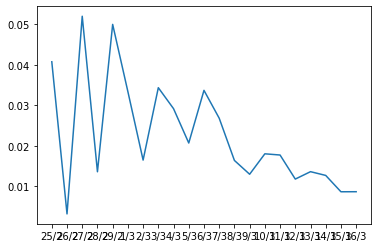

In [128]:
growth_daily_num_ti = np.diff(rows['terapia_intensiva'])
r_factor = growth_daily_num / rows['totale_attualmente_positivi'][:-1]
plt.plot(day_slash_month[1:],r_factor)

array([0.07086614, 0.00666667, 0.12195122, 0.02631579, 0.1002445 ,
       0.06916996, 0.03337612, 0.06938326, 0.05225653, 0.03412553,
       0.05184493, 0.03676471, 0.02579242, 0.01972902, 0.0285205 ,
       0.02552832, 0.01820565, 0.02242727, 0.02170436, 0.01557128,
       0.0157918 ])

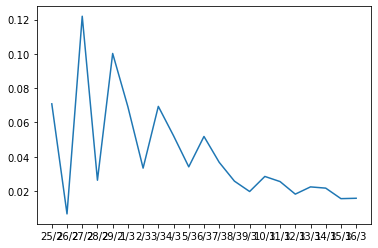

In [132]:
growth_daily_num_ti = np.diff(rows['totale_ospedalizzati'])
r_factor = growth_daily_num / rows['totale_ospedalizzati'][:-1]
plt.plot(day_slash_month[1:],r_factor)
r_factor

In [119]:
r_factor

array([0.40723982, 0.23794212, 0.52727273, 0.3962585 , 0.27771011,
       0.50333651, 0.16360178, 0.23324251, 0.19575784, 0.218034  ,
       0.1881068 , 0.29239019, 0.26200356, 0.25019571, 0.06624922,
       0.24383369, 0.21237016, 0.16481034, 0.18689402, 0.16073239,
       0.11988545])

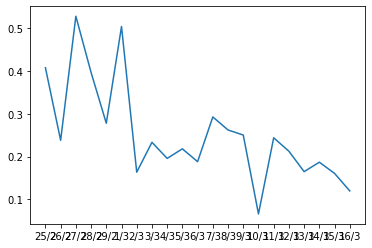

In [121]:
r_factor_mean = np.mean(r_factor)

In [122]:
r_factor_mean

0.252755592572651

In [123]:
221*((1+r_factor_mean)**21)

25094.90916138113